https://github.com/anushkayadav/Denoising_cifar10/blob/master/DnCNN_Denoise.ipynb

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math
from input_corruption import corruption
from data import get_trn_loader, get_val_loader, get_test_loader

ModuleNotFoundError: No module named 'PIL'

In [1]:
!nvidia-smi

Mon Feb  7 17:36:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:2A:00.0 Off |                  N/A |
| 30%   34C    P8    30W / 350W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:B4:00.0 Off |                  N/A |
| 30%   

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
trn_loader, val_loader, test_loader = get_trn_loader(), get_val_loader(), get_test_loader()

NameError: name 'get_trn_loader' is not defined

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [6]:
def gaussian_noise(images, mean=0, sigma=0.5):
    noisy_images = []
    for idx, img in enumerate(images):
        gauss = np.random.normal(mean, sigma, (224, 224))
        noisy_img = img + gauss
        noisy_images.append(noisy_img)
    
    return np.array(noisy_images)

In [1]:
# obtain one batch of training images
dataiter = iter(trn_loader)
images, labels = dataiter.next()

images = images.numpy() 
noisy_imgs = corruption("white", images, 32)
#noisy_imgs=noisy_imgs.numpy()

def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.3 )
        
    plt.show()

NameError: name 'trn_loader' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

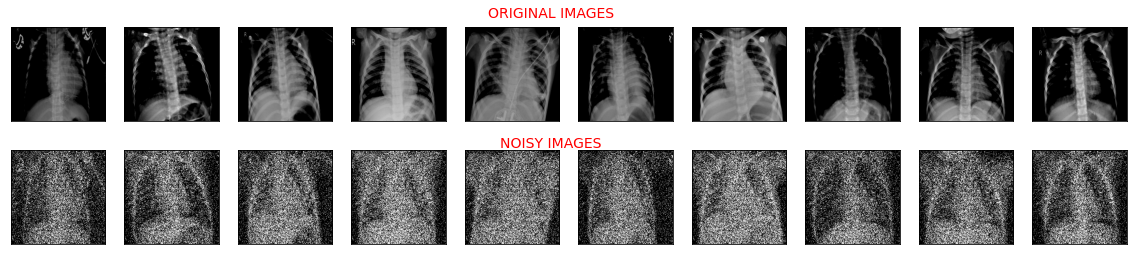

In [11]:
showOrigDec(images, noisy_imgs)

#Denoising

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers = [nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(num_features),
                                        nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 3, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        return y - residual

# initialize the NN
model = DnCNN()
model.cuda()

DnCNN(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [13]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# number of epochs to train the model
n_epochs = 40


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in trn_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # add random noise to the input images
        noisy_imgs = corruption("white", images.numpy(), 32)
        #noisy_imgs = gaussian_noise(images.numpy())
        noisy_imgs = torch.from_numpy(noisy_imgs)
        noisy_imgs = noisy_imgs.type(torch.FloatTensor)
        noisy_imgs = torch.rand_like(noisy_imgs, dtype=torch.float)
        # Clip the images to be between 0 and 1
        #noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicterind outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs.cuda())
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
        del noisy_imgs
        del images
            
    # print avg training statistics 
    train_loss = train_loss/len(trn_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 8.379364
Epoch: 2 	Training Loss: 5.816451
Epoch: 3 	Training Loss: 5.137990
Epoch: 4 	Training Loss: 5.043413
Epoch: 5 	Training Loss: 4.967296
Epoch: 6 	Training Loss: 4.910314
Epoch: 7 	Training Loss: 4.892462
Epoch: 8 	Training Loss: 4.859847
Epoch: 9 	Training Loss: 4.836505
Epoch: 10 	Training Loss: 4.838306
Epoch: 11 	Training Loss: 4.820074
Epoch: 12 	Training Loss: 4.805125
Epoch: 13 	Training Loss: 4.818455
Epoch: 14 	Training Loss: 4.791073
Epoch: 15 	Training Loss: 4.791004
Epoch: 16 	Training Loss: 4.774236
Epoch: 17 	Training Loss: 4.776062
Epoch: 18 	Training Loss: 4.771837
Epoch: 19 	Training Loss: 4.774344
Epoch: 20 	Training Loss: 4.775298
Epoch: 21 	Training Loss: 4.748628
Epoch: 22 	Training Loss: 4.760060
Epoch: 23 	Training Loss: 4.747318
Epoch: 24 	Training Loss: 4.758166
Epoch: 25 	Training Loss: 4.737416
Epoch: 26 	Training Loss: 4.742172
Epoch: 27 	Training Loss: 4.734076
Epoch: 28 	Training Loss: 4.735789
Epoch: 29 	Training Loss: 4.7

In [17]:
torch.save(model,"/home/LNE/Distortions/model/White_DnCNN.pt")

In [20]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = corruption("white", images.numpy(), 32)
noisy_imgs = torch.from_numpy(noisy_imgs)
noisy_imgs = noisy_imgs.type(torch.FloatTensor)
#noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())

# output is resized into a batch of iages
output = output.view(4, 3, 224, 224)
# use detach when it's an output that requires_grad
output = output.detach().cpu()

In [21]:
def showOrigNoiseOut(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = 4
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        imshow(denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="b")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

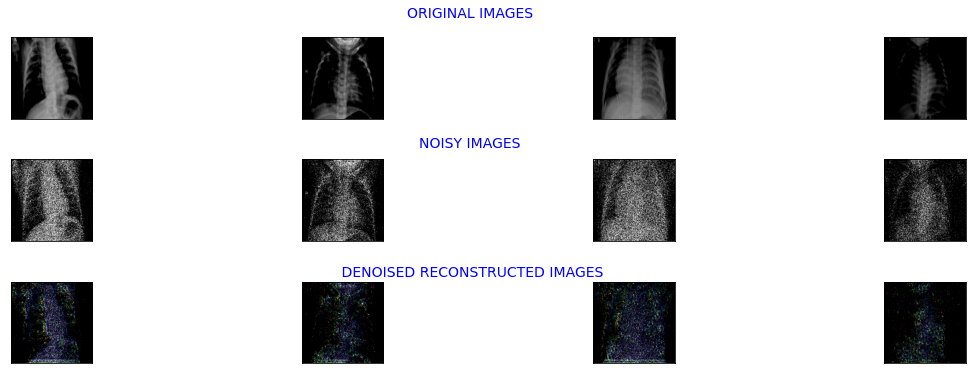

In [19]:
showOrigNoiseOut(images, noisy_imgs, output)